# Preprocessor

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

import re
import emoji
import numpy as np
from nltk.tokenize.casual import EMOTICON_RE
#nltk.download('wordnet')
#nltk.download('words')
from nltk.sentiment.util import mark_negation
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from spellchecker import SpellChecker

from collections import Counter
from wordcloud import WordCloud
from nltk import FreqDist
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', 50) 
label_mapping = {1: 'Negative', 2: 'Neutral', 3: 'Positive'}
input_folder_path = "./pls/Thesis_Jupyter_Final/src/input/"
processed_folder_path = "./pls/Thesis_Jupyter_Final/src/input/processed"
contraction_mapping = {
            "isn't": "is not",
            "aren't": "are not",
            "don't": "do not",
            "doesn't": "does not",
            "wasn't": "was not",
            "weren't": "were not",
            "didn't": "did not",
            "haven't": "have not",
            "hasn't": "has not",
            "hadn't": "had not",
            "won't": "will not",
            "can't": "cannot",
            "couldn't": "could not",
            "shouldn't": "should not",
            "wouldn't": "would not",
            "mightn't": "might not",
            "mustn't": "must not",
            }
emojis = [
    # HAPPY
    ":-)", ":)", ";)", ":o)", ":]", ":3", ":c)", ":>", "=]", "8)",
    "=)", ":}", ":^)", ":-D", ":D", "8-D", "8D", "x-D", "xD", "X-D",
    "XD", "=-D", "=D", "=-3", "=3", ":-))", ":'-)", ":')", ":*", ":^*",
    ">:P", ":-P", ":P", "X-P", "x-p", "xp", "XP", ":-p", ":p", "=p",
    ":-b", ":b", ">:)", ">;)", ">:-)", "<3",

    # SAD
    ":L", ":-/", ">:/", ":S", ">:[", ":@", ":-(", ":[", ":-||", "=L", 
    ":<", ":-[", ":-<", "=\\", "=/", ">:(", ":(", ">.<", ":'-(", ":'(",
    ":\\", ":-c", ":c", ":{", ">:\\", ";("
]

# Create the folder if it doesn't exist
if not os.path.exists(processed_folder_path):
    os.makedirs(processed_folder_path)

Goal of project: 

This notebook includes: (steps)

# Load Data

First, we load and explore the dataset and apply some initial processing such as setting the '*Id*' column as index and removing any empty rows.

In [2]:
def drop_missing(data):
    # Remove any rows with missing values and reset the index
    rows_before = data.shape[0] 

    data.replace('', np.nan, inplace=True)
    data = data.dropna()
    data.reset_index(drop=True, inplace=True)

    rows_after = data.shape[0]
    # Count the number of rows removed
    print(f"Number of removed rows: {rows_before - rows_after}")

    return data

In [3]:
def load_data(filename, process=True):
    # Load data
    data_file_path = os.path.join(input_folder_path, filename)
    df = pd.read_csv(data_file_path)

    if process:
        # Set ID as index
        df.set_index('Id', inplace=True, drop=True)
        df = drop_missing(df)

        print(df.info())
        print()
        print(f'Dataset shape: {df.shape}\n')

    return df

data_filename = "original_data.csv"
df_original = load_data(data_filename)

Number of removed rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107018 entries, 0 to 107017
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Review     107018 non-null  object
 1   Sentiment  107018 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB
None

Dataset shape: (107018, 2)



In [4]:
df_original.head(20)

,Review,Sentiment
0,good and interesting,3
1,"This class is very helpful to me. Currently, I...",3
2,like!Prof and TAs are helpful and the discussi...,3
3,Easy to follow and includes a lot basic and im...,3
4,Really nice teacher!I could got the point eazl...,3
5,"Great course - I recommend it for all, especia...",3
6,One of the most useful course on IT Management!,3
7,I was disappointed because the name is mislead...,2
8,Super content. I'll definitely re-do the course,3
9,One of the excellent courses at Coursera for i...,3


### Analysing Data 
We then analyse the dataset by observing the distribution of review per sentiment.

Analyzing General data
3 (Positive): 97227 reviews (90.85%)
2 (Neutral): 5071 reviews (4.74%)
1 (Negative): 4720 reviews (4.41%)


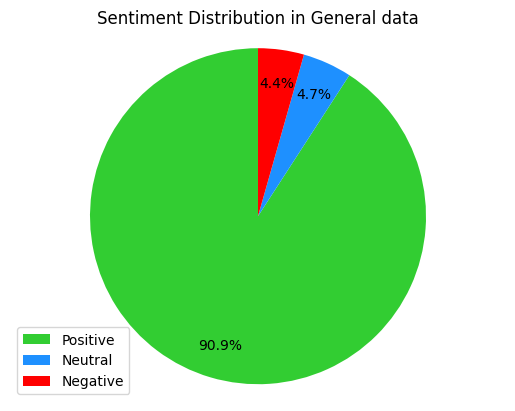

Total word count:  2661665
Average review length: 24.87



In [5]:
def print_senti_counts(counts):
     # Print the number of reviews per sentiment and their percentage
    total_count = sum(counts)
    for senti, count in counts.items():
        sentiment_name = label_mapping[senti]
        percent = (count / total_count) * 100
        print(f"{senti} ({sentiment_name}): {count} reviews ({percent:.2f}%)")


def plot_senti_counts(counts, df_type):
    # Plot counts per sentiment
    colors = ['limegreen', 'dodgerblue', 'red']
    plt.pie(counts, colors=colors, autopct='%1.1f%%',  pctdistance=0.8, textprops={'fontsize': 10, 'color': 'black'}, startangle=90)
    plt.axis('equal')  # pie as a circle
    plt.legend(labels=list(label_mapping.values())[::-1], loc='lower left')
    plt.title(f"Sentiment Distribution in {df_type} data")
    plt.show()

def count_words(text):
    # Count words per review
    return len(str(text).split(' '))

def analyse_data(df_x, df_y, df_type, plot=True):
    # Call all the data analysis functions at once
    print(f"Analyzing {df_type} data")
    
    senti_counts = df_y.value_counts()
    print_senti_counts(senti_counts)
    if plot:
        plot_senti_counts(senti_counts, df_type)

    # Calculate total and average word count without adding a new column to the dataframe
    total_word_count = df_x.apply(count_words).sum()
    avg_review_len = df_x.apply(count_words).mean()

    print("Total word count: ", total_word_count)
    print(f"Average review length: {avg_review_len:.2f}\n")


analyse_data(df_original['Review'], df_original['Sentiment'], "General")

## Clean Text

Next, we clean the data applying the following techniques (TODO: add info):

In [6]:
def clean_data(df):
    # 1) Lowercase
    df['Review'] = df['Review'].str.lower()

    # 2) Replace contractions with their standard full forms
    for contraction, standard in contraction_mapping.items():
        df['Review'] = df['Review'].str.replace(contraction, standard)

    # 3) Remove punctuation in between words e.g. "course.sometimes", "i'll" and replace with space
    pattern = r'(?<=\w)[^\w\s]+(?=\w)'
    df['Review'] = df['Review'].str.replace(pattern, ' ', regex=True)
    df['Review'] = df['Review'].str.replace(r'\.{2,}', ' ', regex=True) 

    # 4) Tokenize text into individual words (removes all extra spaces \s)
    tokenizer = TweetTokenizer()
    df['Review'] = df['Review'].apply(tokenizer.tokenize)

    # 5) Remove punctuation first in between words (typo), and then all punctuation and numerals except for tokenized emojis
    pattern = r"[^\w\s" + "".join(re.escape(e) for e in emojis + list(emoji.EMOJI_DATA.keys())) + "]|[\d]+" # match non-emoji special characters
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if not re.match(pattern, token)])

    # 6) Remove single characters
    df['Review'] = df['Review'].apply(lambda tokens: [word for word in tokens if len(word) > 1])

    # 8) Perform negation tagging
    df['Review'] = df['Review'].apply(mark_negation)

    # 9) Remove stopwords --> also removes words like 'not'
    stop_words = set(stopwords.words('english'))
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
    df['Review'] = df['Review'].apply(lambda tokens: [token for token in tokens if token.split('_')[0] not in stop_words])

     # 10) Lemmatize words using WordNetLemmatizer (also lemmatizes words removing _NEG)
    def lemmatize_token(token):
        lemmatizer = WordNetLemmatizer()
        if "_NEG" in token:
            word, tag = token.split("_NEG")
            return lemmatizer.lemmatize(word) + "_NEG"
        else:
            return lemmatizer.lemmatize(token)

    df['Review'] = df['Review'].apply(lambda tokens: [lemmatize_token(token) for token in tokens])

    # Convert preprocessed tokens back to string
    df['Review'] = df['Review'].apply(' '.join)

    return df


# Create a copy of the original DataFrame to preserve the original data
df_clean = df_original.copy()
# Apply preprocessing
df_clean = clean_data(df_clean) 
# Remove NaN rows, after cleaning text
df_clean = drop_missing(df_clean) 
print(f'Dataset shape (after text cleaning): {df_clean.shape}\n')

Number of removed rows: 31
Dataset shape (after text cleaning): (106987, 2)



In [7]:
df_clean.head(20)

,Review,Sentiment
0,good interesting,3
1,class helpful currently still learning class m...,3
2,like prof ta helpful discussion among student ...,3
3,easy follow includes lot basic important techn...,3
4,really nice teacher could got point eazliy,3
5,great course recommend especially business man...,3
6,one useful course management,3
7,disappointed name misleading course provides g...,2
8,super content definitely course,3
9,one excellent course coursera information tech...,3


In [8]:
def save_to_csv(df, file_path):
    df.to_csv(file_path, sep=',', index_label='Id')

clean_data_filename = "clean_data.csv"
data_file_path = os.path.join(input_folder_path, clean_data_filename)
save_to_csv(df_clean, data_file_path)

# Preprocess Data

First we load cleaned data.

In [9]:
clean_data_filename = "clean_data.csv"
loaded_clean_df = load_data(clean_data_filename, process=False)

### Split train and test

In [10]:
def split_train_test(review_col, sentiment_col):
    # Split dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(review_col, sentiment_col, stratify=sentiment_col, test_size=0.2, random_state=42) # Stratify ensures proportional sampling
    # Split the training dataset further into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

    print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))

    return x_train, y_train, x_val, y_val, x_test, y_test


x_train, y_train, x_val, y_val, x_test, y_test = split_train_test(loaded_clean_df['Review'], loaded_clean_df['Sentiment'])
analyse_data(x_train, y_train, "Training", plot=False)
analyse_data(x_val, y_val, "Validation", plot=False)
analyse_data(x_test, y_test, "Testing", plot=False)

Data Distribution:
* train: 68471
* validation: 17118
* test: 21398

Analyzing Training data
3 (Positive): 62208 reviews (90.85%)
2 (Neutral): 3245 reviews (4.74%)
1 (Negative): 3018 reviews (4.41%)
Total word count:  908178
Average review length: 13.26

Analyzing Validation data
3 (Positive): 15552 reviews (90.85%)
2 (Neutral): 811 reviews (4.74%)
1 (Negative): 755 reviews (4.41%)
Total word count:  228249
Average review length: 13.33

Analyzing Testing data
3 (Positive): 19441 reviews (90.85%)
2 (Neutral): 1014 reviews (4.74%)
1 (Negative): 943 reviews (4.41%)
Total word count:  286560
Average review length: 13.39



In [11]:
x_train.head(100)

13522                                awesome helpful course
86366     took longer hoped complete course satisfying f...
89832                              good introduction python
65107     good introduction rail well organized structur...
11488     well structured thoughtful course delivered tr...
106741    found course good introduction review beginner...
74389     course well structured auto grader really stre...
35075                              like though finished_NEG
53637                    really nice course starter ai algo
81174                   answer always first option like_NEG
98065     congratulation course great experience learn t...
98957     awesome course took u database learning intera...
73044     really enjoyed historical background course pr...
42690                  great course mandatory coursera user
48749                                        great learning
30058             loved course learnt lot hope put good use
29919                 interesting course

### Create & Analyse Vocabulary

### Analysis Functions

In [12]:
def plot_word_freq_cdf(word_counts, min_cutoff, max_cutoff):
    # Calculate the cumulative sum of the sorted frequencies & normalize
    cumu_counts = np.cumsum(word_counts)
    cdf = cumu_counts / cumu_counts[-1]

    # Plot the CDF
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(1, len(cdf) + 1), cdf)
    plt.axvline(x=min_cutoff, color='r', linestyle='--')
    plt.axvline(x=max_cutoff, color='r', linestyle='--')
    #plt.xscale('log')
    plt.xlabel('Word Rank')
    plt.ylabel('Cumulative Frequency')
    plt.title('CDF of Word Frequencies')
    plt.grid(True)
    plt.show()

def calculate_word_statistics(freqs):

    print("Mean frequency: ", np.mean(freqs))
    print("Median frequency: ", np.median(freqs))
    print("Max frequency: ", max(freqs))
    print("Min frequency: ", min(freqs))
    print("Standard deviation: ", np.std(freqs))
    print("1st quartile: ", np.percentile(freqs, 25))
    print("3rd quartile: ", np.percentile(freqs, 75))

def create_wordcloud(word_counts):
    wordcloud = WordCloud().generate_from_frequencies(word_counts)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

def plot_word_freq_hist(word_counts):
    # Plot word frequency distribution with logarithmic scale
    plt.figure(figsize=(10, 5))
    plt.hist(word_counts, bins=range(1, 500, 10), alpha=0.5)
    plt.yscale('log')
    plt.title('Word Frequency Distribution (Logarithmic Scale)')
    plt.xlabel('Word Frequency')
    plt.ylabel('Number of Words')

def plot_word_freq_most_common(dataset, num_most_common=60):
    all_words = [word for review in dataset for word in review.split()]

    fdist = FreqDist(all_words)
    plt.figure(figsize=(10, 5))
    fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
    plt.show()

def plot_word_freq_most_common(dataset, labels=None, num_most_common=50, per_class=False):
    if per_class:
        class_words = {}
        # Combine dataset and labels into one list for processing
        for review, label in zip(dataset, labels):
            if label not in class_words:
                class_words[label] = []
            class_words[label].extend(review.split())
            
        for class_label, words in class_words.items():
            fdist = FreqDist(words)
            plt.figure(figsize=(10, 5))
            fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens in Class {label_mapping[class_label]}')
            plt.show()
    else:
        all_words = [word for review in dataset for word in review.split()]
        fdist = FreqDist(all_words)
        plt.figure(figsize=(10, 5))
        fdist.plot(num_most_common, title=f'Frequency Distribution of Most Common {num_most_common} Tokens')
        plt.show()


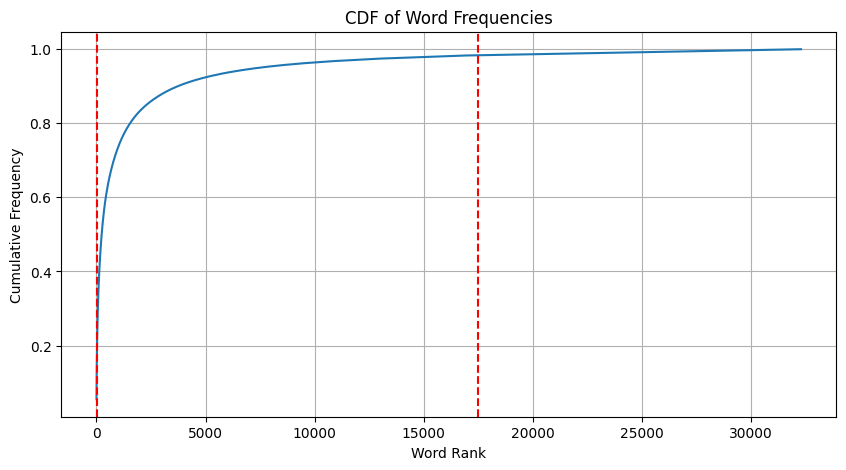

Min Freq: 1
Max Freq: 2482

Stored 'vocab' (dict)
Stored 'vocab_size' (int)


In [13]:
def create_vocab(data, min_cutoff, max_cutoff):
    # Calculate frequency of words in the training set
    original_vocab = Counter()
    for review in data:
        original_vocab.update(review.split())
    
    # Calculate cdf
    counts = np.array(list(original_vocab.values()))
    counts_sorted = np.sort(counts)[::-1] # descending
    plot_word_freq_cdf(counts_sorted, min_cutoff, max_cutoff)

    # Convert the cutoff values in terms of rank to the actual frequency values
    min_freq = counts_sorted[max_rank_cutoff - 1]  # -1 since 0-based indexing
    max_freq = counts_sorted[min_rank_cutoff - 1] 
    print(f"Min Freq: {min_freq}\nMax Freq: {max_freq}\n")

    # Filter vocabulary by removing words with frequency less than a set minimum frequency
    vocab = {token: freq for token, freq in original_vocab.items() if min_freq <= freq <= max_freq}
    vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))
    vocab_size = len(vocab)
    
    # Save vocab freqs to check
    vocab_data_filename = "vocab.txt"
    file_path = os.path.join(processed_folder_path, vocab_data_filename)
    with open(file_path, 'w') as f:
        for token, freq in vocab.items():
            f.write(f"{token}\t{freq}\n")

    # Save vocab
    vocab_data_filename = "vocab.pkl"
    file_path = os.path.join(processed_folder_path, vocab_data_filename)
    with open(file_path, 'wb') as f:
        pickle.dump(vocab, f)


    return original_vocab, vocab, vocab_size

# VOCAB-CONSTANTS
min_rank_cutoff = 40
max_rank_cutoff = 17500

original_vocab, vocab, vocab_size = create_vocab(x_train, min_rank_cutoff, max_rank_cutoff)
%store vocab
%store vocab_size

--Original Vocab--
50 Most common words in Original-Vocabulary: [('course', 50054), ('great', 15598), ('good', 12283), ('really', 7816), ('course_NEG', 7360), ('well', 6355), ('lot', 6288), ('learning', 6236), ('excellent', 5829), ('interesting', 5231), ('thank', 4821), ('learn', 4595), ('useful', 4067), ('would', 4038), ('much', 3920), ('easy', 3916), ('material', 3768), ('way', 3659), ('assignment', 3655), ('thanks', 3578), ('one', 3505), ('understand', 3471), ('like', 3436), ('lecture', 3327), ('basic', 3324), ('professor', 3160), ('content', 3156), ('video', 3109), ('class', 3098), ('learned', 3011), ('introduction', 2998), ('time', 2928), ('concept', 2920), ('best', 2920), ('teacher', 2870), ('helpful', 2848), ('recommend', 2721), ('information', 2657), ('nice', 2519), ('programming', 2482), ('knowledge', 2448), ('enjoyed', 2442), ('clear', 2371), ('work', 2356), ('also', 2298), ('make', 2254), ('instructor', 2235), ('help', 2235), ('topic', 2185), ('thing', 2167)]

Mean frequency

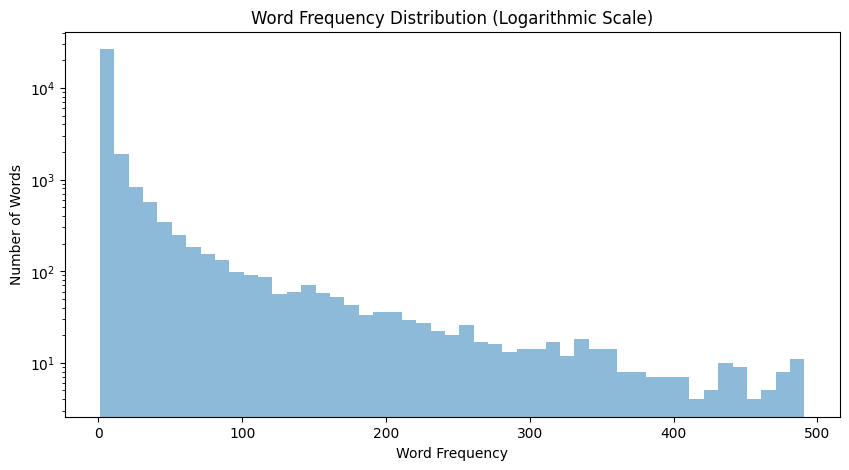

In [14]:
def analyze_vocab(original_vocab, vocab, vocab_size):
    # Analyse original vocabulary
    print("--Original Vocab--")
    print(f"50 Most common words in Original-Vocabulary: {original_vocab.most_common(50)}\n") # TODO: use to show what is deleted in report, the delete
    calculate_word_statistics(np.array(list(original_vocab.values())))
    print("After filtering, vocabulary size of {} reduced to {}.\n".format(len(original_vocab), vocab_size))

    # Analyse filtered vocabulary
    print("--Filtered Vocab--")
    #vocab = dict(sorted(vocab.items(), key=lambda x: x[1], reverse=True))
    first_20 = list(vocab.items())[:10]
    print("20 Most Common Words:")
    for word, freq in first_20:
        print(f"\t{word}: {freq}")
    print()

    freqs = np.array(list(vocab.values()))
    calculate_word_statistics(freqs)
    #create_wordcloud(vocab)
    plot_word_freq_hist(freqs)


analyze_vocab(original_vocab, vocab, vocab_size)

The vocabulary is heavily skewed, with a low median (2) compared to the mean (28.47) and max frequency (50168), suggesting that there are a lot of infrequent words and a few very high frequency words.

#### Filter data with vocabulary

In [15]:
def merge_data(x, y):
    merged = pd.concat([x, y], axis=1)
    merged.columns = ['x', 'y']
    
    return merged

def filter_and_drop_empty_rows(x_data, y_data, vocab):
    # Filter dataset based on vocabulary
    filtered_dataset = []
    for doc in x_data:
        filtered_text = ' '.join([word for word in doc.split() if word in vocab])
        filtered_dataset.append(filtered_text)

    filtered_dataset = pd.Series(filtered_dataset, index=x_data.index)
    
    # Save the filtered data
    with open("filt.txt", "w") as f:
        for item in filtered_dataset[:100]:
            f.write("%s\n" % item)
    
    # Merge filtered dataset and y_data and drop empty rows
    merged = merge_data(filtered_dataset, y_data)
    
    merged.replace('', np.nan, inplace=True)
    merged.dropna(subset=['x'], inplace=True) # TODO: subset?

    # Re-assign X and Y datasets
    x_filtered = merged['x']
    y_filtered = merged['y']

    # Save the empty data
    with open("empty.txt", "w") as f:
        for item in x_filtered[:100]:
            f.write("%s\n" % item)

    return x_filtered, y_filtered

# Apply the combined function
x_train, y_train = filter_and_drop_empty_rows(x_train, y_train, vocab)
x_val, y_val = filter_and_drop_empty_rows(x_val, y_val, vocab)
x_test, y_test = filter_and_drop_empty_rows(x_test, y_test, vocab)
print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))


Data Distribution:
* train: 63236
* validation: 15777
* test: 19729



Training Data: 


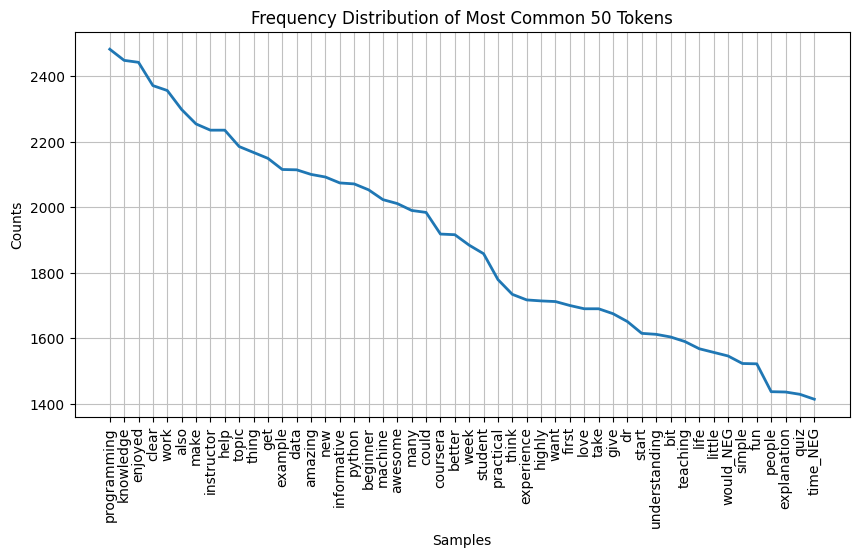

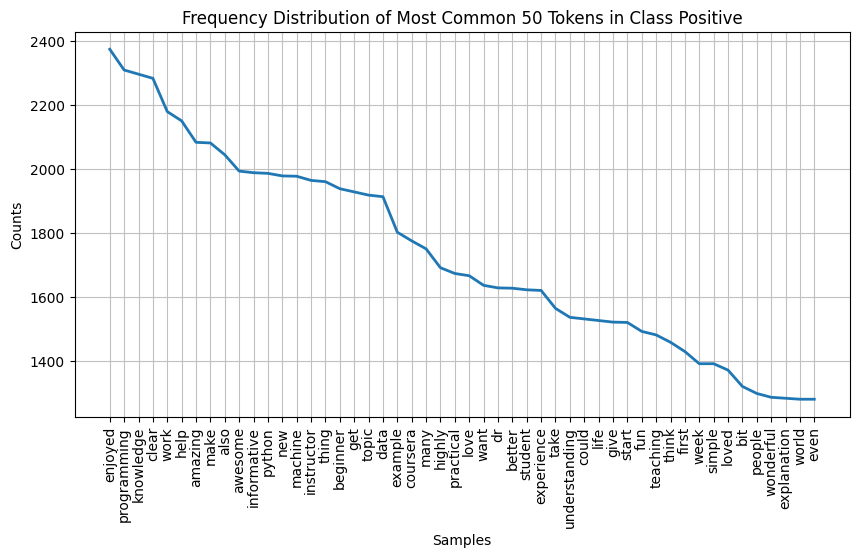

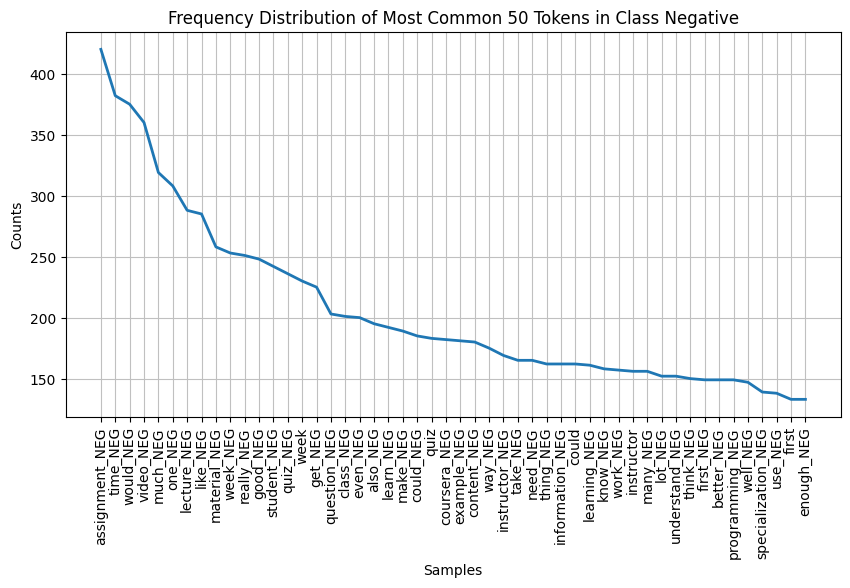

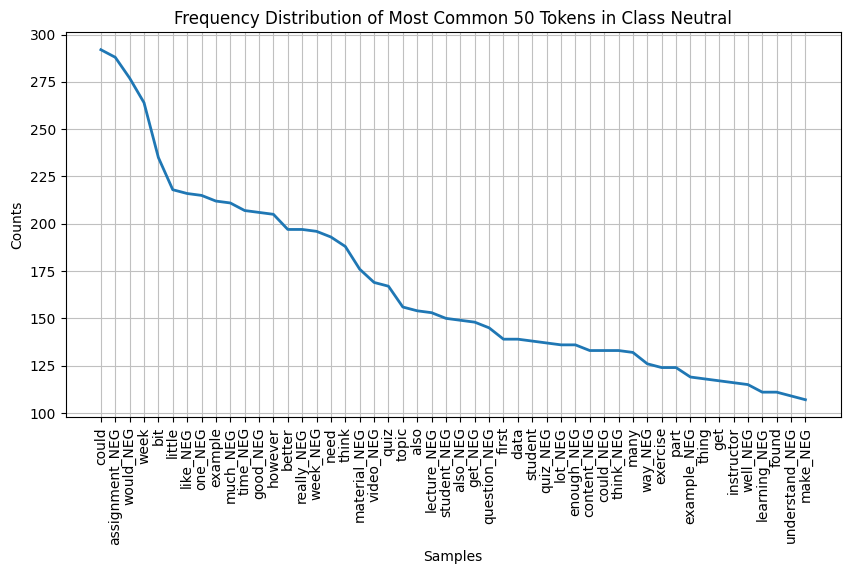

Analyzing Training data
3 (Positive): 57054 reviews (90.22%)
2 (Neutral): 3185 reviews (5.04%)
1 (Negative): 2997 reviews (4.74%)
Total word count:  687133
Average review length: 10.87



In [16]:
def analyse_train_data(x_train, y_train):
    print("Training Data: ")
    plot_word_freq_most_common(x_train)
    plot_word_freq_most_common(x_train, labels=y_train, num_most_common=50, per_class=True)
    analyse_data(x_train, y_train, "Training", plot=False)


analyse_train_data(x_train, y_train)

# Balance Data

We remove positive reviews that have 3 words or less...

Data Distribution:
* train: 45347
* validation: 15777
* test: 19729

Analyzing Training data
3 (Positive): 39165 reviews (86.37%)
2 (Neutral): 3185 reviews (7.02%)
1 (Negative): 2997 reviews (6.61%)


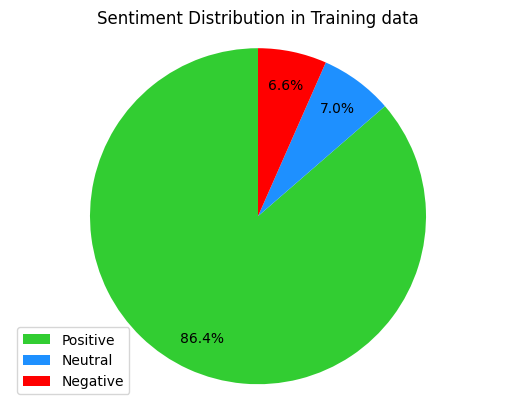

Total word count:  652506
Average review length: 14.39



In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 50) 

def remove_pos_under_3(x_train, y_train):
    df_train = merge_data(x_train, y_train)

    df_train['word_counts'] = df_train['x'].apply(lambda x: len(x.split()))

    # Filter rows based on the condition
    df_train = df_train[(df_train['word_counts'] > 3) | (df_train['y'] != 3)]

    # Split the DataFrame back into x_train and y_train
    x_train_filtered = df_train['x']
    y_train_filtered = df_train['y']

    return x_train_filtered, y_train_filtered

x_train, y_train = remove_pos_under_3(x_train, y_train)
print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
analyse_data(x_train, y_train, "Training")

In [18]:
# The "strategy" parameter can take a dict, callable, or str as input
# You might need to adjust these parameters according to the distribution of your classes
over_strategy = {1: 10500, 2: 10500} # Over-sample minority classes 10000
under_strategy = {3: 20000} # Under-sample majority classes 40000

# Define pipeline
over = RandomOverSampler(sampling_strategy=over_strategy)
under = RandomUnderSampler(sampling_strategy=under_strategy)
pipeline = Pipeline(steps=[('o', over), ('u', under)])

# Applying the balancing pipeline to both x and y datasets
x_balanced, y_balanced = pipeline.fit_resample(pd.DataFrame(x_train), y_train)

# Print out the new class distribution
counter = Counter(y_balanced)
print(counter)

x_train = x_balanced.copy()
y_train = y_balanced.copy()


Counter({3: 20000, 1: 10500, 2: 10500})


In [19]:
print(x_train.shape, y_train.shape)
print(x_train[:5])

(41000, 1) (41000,)
                                                   x
0  bad superficial explanation instructor speaks ...
1  first let grade quiz purchase highly disappointed
2  horrible test make little sense use element de...
3  least favorite ere informative_NEG far_NEG lof...
4  guess thing explanation level_NEG assignment_N...


Data Distribution:
* train: 41000
* validation: 15777
* test: 19729

Analyzing Training data
3 (Positive): 20000 reviews (48.78%)
1 (Negative): 10500 reviews (25.61%)
2 (Neutral): 10500 reviews (25.61%)


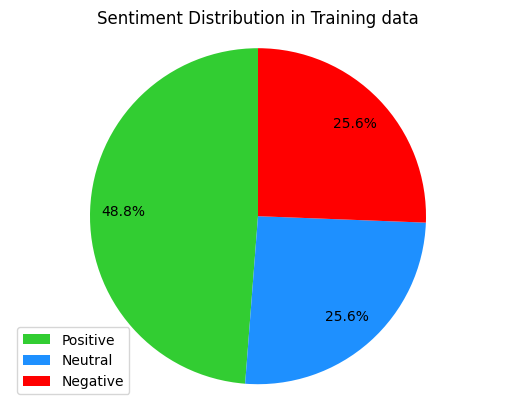

Total word count:  586870
Average review length: 586870.00



In [20]:
print("Data Distribution:\n* train: {}\n* validation: {}\n* test: {}\n".format(len(x_train), len(x_val), len(x_test)))
analyse_data(x_train, y_train, "Training")

In [21]:
save_to_csv(merge_data(x_train, y_train), os.path.join(input_folder_path, "train.csv"))
save_to_csv(merge_data(x_val, y_val), os.path.join(input_folder_path, "val.csv"))
save_to_csv(merge_data(x_test, y_test), os.path.join(input_folder_path, "test.csv"))